<a href="https://colab.research.google.com/github/AdanALalawni/DiamondPricePrediction/blob/main/DiamondPricePrediction_Using_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explore Data

In [1]:
import pandas as pd

In [2]:
data=pd.read_csv('https://raw.githubusercontent.com/AdanALalawni/DiamondPricePrediction/main/diamonds.csv')
data.head(10)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [3]:
data.drop('Unnamed: 0',axis=1,inplace=True)
data.head(3)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31


In [4]:
data.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [5]:
data.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

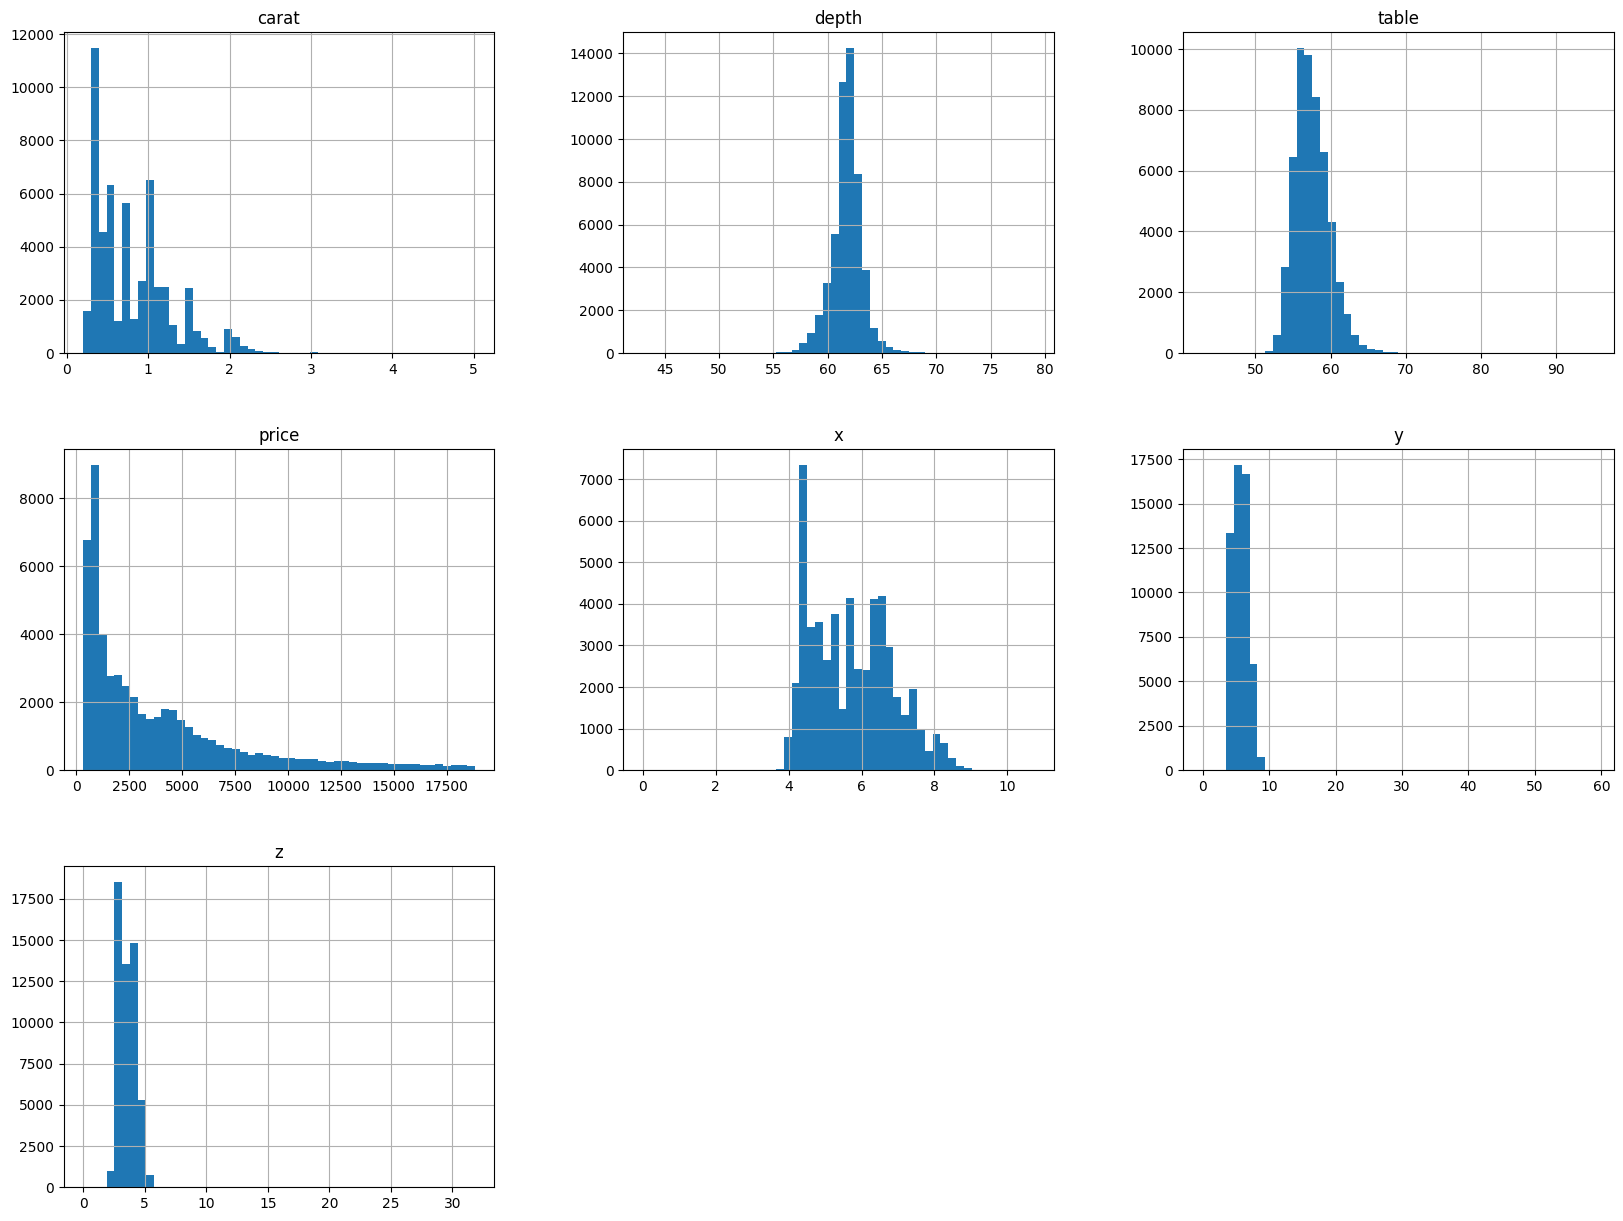

In [7]:
data.hist(bins=50,figsize=(20,15))
plt.show()

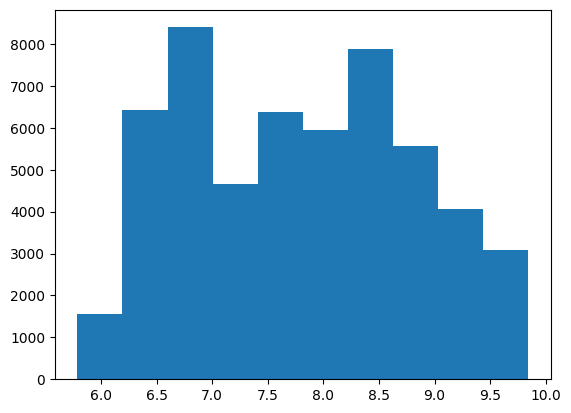

In [8]:
import numpy as np
plt.hist(np.log(data['price']))
data['price']=np.log(data['price'])
plt.show()

# Build an XGBoost DMatrix

In [9]:
from sklearn.model_selection import train_test_split
# split data
x, y = data.drop('price',axis=1),data[['price']]

*we have three categorical columns , XGBoost can deal with it.no need for one_hot encode,but we must change their type to category data type*

In [10]:
cat=x.select_dtypes(include='object').columns
for col in cat:
    x[col]=x[col].astype('category')

In [11]:
# split data(train,test) data sets
x_train ,x_test,y_train ,y_test=train_test_split(x,y, test_size=0.2,random_state=1)

*XGBoost comes with its own class for storing datasets called DMatrix. It is a highly optimized class for memory and speed.*




Why are we going with the native API of XGBoost, rather than its Scikit-learn API? While it might be more comfortable to use the Sklearn API at first, later, you’ll realize that the native API of XGBoost contains some excellent features that the former doesn’t support. So, better get used to it from the beginning. However, there is a section at the end where we show how to switch between APIs in a single line of code even after you have trained models.

In [12]:
import xgboost as xgb
from xgboost import DMatrix
dtrain_reg= DMatrix(data=x_train ,label=y_train ,enable_categorical=True)
dtest_reg= DMatrix(data=x_test ,label=y_test ,enable_categorical=True)

*a loss function should be minimized while a metric should be maximized. A loss function is used during training to guide the model on where to improve. A metric is used during evaluation to measure overall performance*

In [13]:
# train model
# n : number of boosting rounds
n=100
param={"objective":"reg:squarederror" ,"tree_method":"hist"}
model=xgb.train(params=param ,
                dtrain=dtrain_reg ,
                num_boost_round=n)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
y_pred=model.predict(dtest_reg)
print({mean_squared_error(y_test,y_pred,squared=False)})
print(mean_absolute_percentage_error(y_test,y_pred)*100)

{0.08678256597553703}
0.8102137603219768


*we can enhance the performnce of model using tow methods *:

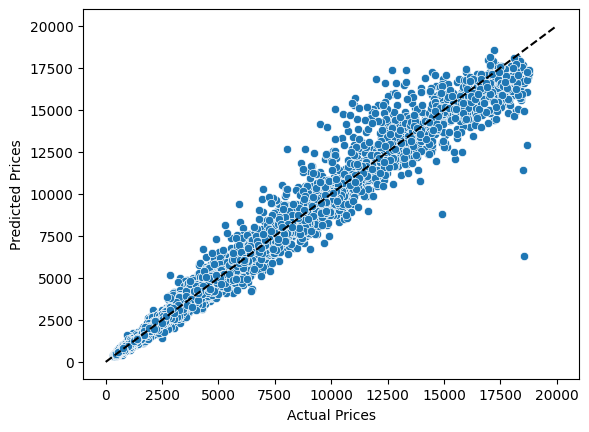

In [15]:
sns.scatterplot(x=np.exp(y_test).values.flatten(),y=np.exp(y_pred).flatten()) # Use .values to extract the NumPy array from the DataFrame
plt.plot([0,20000], [0,20000],'k--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()


In [16]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.9925527217349721

In [17]:
df=pd.DataFrame(x_test)
df['price']=np.exp(y_test)
df['predicted_price']=np.exp(y_pred)

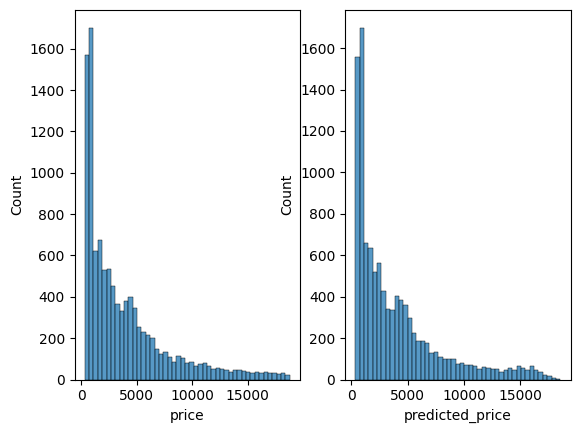

In [18]:
plt.subplot(1,2,1)
sns.histplot(df['price'])
plt.subplot(1,2,2)
sns.histplot(df['predicted_price'])
plt.show()

# Using Validation Sets During Training

In [19]:
eval_set=[(dtrain_reg,'train'),(dtest_reg,'validation')]

In [20]:
model=xgb.train(params=param ,
                dtrain=dtrain_reg ,
                num_boost_round=n,
                evals=eval_set)

[0]	train-rmse:0.72267	validation-rmse:0.71498
[1]	train-rmse:0.51760	validation-rmse:0.51255
[2]	train-rmse:0.37576	validation-rmse:0.37234
[3]	train-rmse:0.27871	validation-rmse:0.27678
[4]	train-rmse:0.21351	validation-rmse:0.21242
[5]	train-rmse:0.17093	validation-rmse:0.17067
[6]	train-rmse:0.14331	validation-rmse:0.14352
[7]	train-rmse:0.12653	validation-rmse:0.12735
[8]	train-rmse:0.11519	validation-rmse:0.11625
[9]	train-rmse:0.10849	validation-rmse:0.10995
[10]	train-rmse:0.10400	validation-rmse:0.10578
[11]	train-rmse:0.10100	validation-rmse:0.10305
[12]	train-rmse:0.09874	validation-rmse:0.10092
[13]	train-rmse:0.09723	validation-rmse:0.09963
[14]	train-rmse:0.09591	validation-rmse:0.09864
[15]	train-rmse:0.09466	validation-rmse:0.09764
[16]	train-rmse:0.09396	validation-rmse:0.09702
[17]	train-rmse:0.09252	validation-rmse:0.09578
[18]	train-rmse:0.09170	validation-rmse:0.09518
[19]	train-rmse:0.09120	validation-rmse:0.09482
[20]	train-rmse:0.09054	validation-rmse:0.09427
[2

In [21]:
n=5000
model=xgb.train(params=param ,
                dtrain=dtrain_reg ,
                num_boost_round=n,
                verbose_eval=50,
                early_stopping_rounds=50,
                evals=eval_set)

[0]	train-rmse:0.72267	validation-rmse:0.71498
[50]	train-rmse:0.08172	validation-rmse:0.08901
[100]	train-rmse:0.07461	validation-rmse:0.08678
[150]	train-rmse:0.06986	validation-rmse:0.08606
[200]	train-rmse:0.06651	validation-rmse:0.08572
[240]	train-rmse:0.06386	validation-rmse:0.08576


In [22]:
print(mean_squared_error(y_test,model.predict(dtest_reg),squared=False))
print(mean_absolute_percentage_error(y_test,model.predict(dtest_reg))*100)
print(r2_score(y_test,model.predict(dtest_reg)))

0.08577081751554723
0.7902312214264436
0.9927253566513107


# XGBoost Cross-Validation
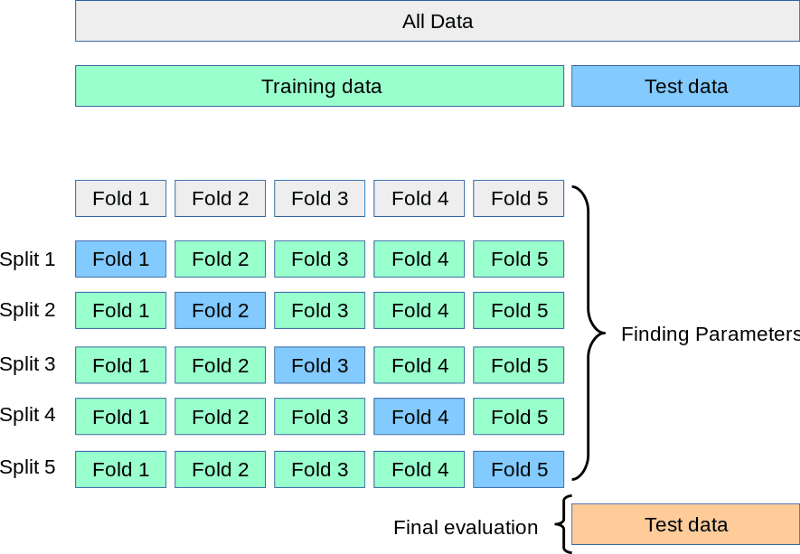

In [23]:
n=1000
result=xgb.cv(
    param,dtrain_reg,
    num_boost_round=n,
    nfold=5,
    early_stopping_rounds=50
    )

In [24]:
result.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.722653,0.000536,0.722906,0.002028
1,0.517663,0.000360,0.518088,0.001604
2,0.376056,0.000350,0.376822,0.001214
3,0.279336,0.000172,0.280535,0.001005
4,0.214120,0.000275,0.215792,0.000908


In [27]:
print(min(result['test-rmse-mean']))

0.08942512472820621


In [32]:
df=pd.DataFrame(x_test)
df['price']=np.exp(y_test)
df['predicted_price']=np.exp(y_pred)
df

,carat,cut,color,clarity,depth,table,x,y,z,price,predicted_price
2714,0.33,Ideal,H,SI1,61.7,55.0,4.43,4.46,2.74,564.0,478.086243
14653,1.20,Ideal,I,VS2,62.1,57.0,6.78,6.71,4.19,5914.0,5672.401367
52760,0.62,Ideal,D,VS1,61.0,57.0,5.51,5.54,3.37,2562.0,2601.674805
48658,0.34,Good,H,VS2,63.1,56.0,4.41,4.46,2.80,537.0,503.268921
14812,1.20,Ideal,E,SI2,62.5,55.0,6.77,6.84,4.25,5964.0,5966.184570
...,...,...,...,...,...,...,...,...,...,...,...
49568,0.67,Good,G,VS2,57.5,60.1,5.78,5.83,3.34,2131.0,1986.360840
32163,0.28,Ideal,F,IF,62.6,53.0,4.18,4.19,2.62,787.0,799.563416
52459,0.70,Fair,F,VS2,66.4,53.0,5.51,5.49,3.65,2516.0,2340.863037
15265,1.20,Premium,H,SI1,61.0,58.0,6.92,6.84,4.20,6129.0,6046.179688
